In [1]:
import numpy as np
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pickle

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})

In [28]:
with open('/home/fverdian/class/soundspeed-scripts/1loop/Pk-lin-int.pkl', 'rb') as f:
    Plin_int = pickle.load(f)
fact=(2*np.pi)**3

def F3(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    kMq2 = k2 + q2 - 2*k*q*mu 
    kPq2 = k2 + q2 + 2*k*q*mu 

    res1 = 1/kMq2*(5/126*k2-11/108*k*q*mu+7/108*q2*mu2-1/54*k2*k2*mu2/q2+4/189*k2*k*mu2*mu/q-23/756*k2*k*mu/q+25/252*k2*mu2-2/27*k*q*mu2*mu)
    res2 = 1/kPq2*(5/126*k2+11/108*k*q*mu-7/108*q2*mu2-4/27*k2*k2*mu2/q2-53/189*k2*k*mu2*mu/q+23/756*k2*k*mu/q-121/756*k2*mu2-5/27*k*q*mu2*mu)
    return res1+res2

def F2(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    kMq2 = k2 + q2 - 2*k*q*mu 
    return (k2*(7*k*q*mu+3*q2)-10*k2*q2*mu2)/(14*q2*kMq2)

def alpha(k1,k2,cT):
    return 1+cT*k2/k1

def alphas(k1,k2,cT):
    return 1+0.5*cT*(k2/k1+k1/k2)

def beta(k1,k2,cT):
    t1=k1*k1+k2*k2+2*k1*k2*cT
    t2=k1*k2*cT
    t3=2.*k1*k1*k2*k2
    return t1*t2/t3

def F2_EdS(k1,k2,cT):
    return (5./7.)*alphas(k1,k2,cT)+(2./7.)*beta(k1,k2,cT)

def DeltaF2_midlim(mu):
    return -3*(23+12*mu**2)/490

In [21]:
fx=0.1
fullt=np.linspace(-10,20, 200)
teval=0
idx_eta=np.abs(fullt - (0.)).argmin()
kref=0.1
supprshift=5

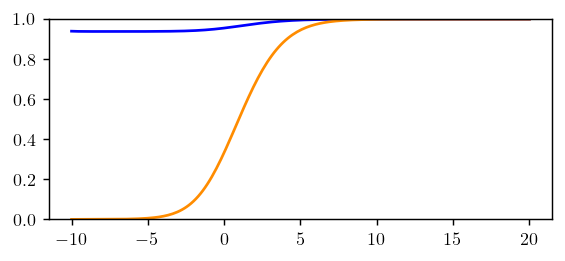

In [22]:
# this is solved fot k=0.1 (for which tildeeta = eta) and then I shift it using the smmetry
def lin_system(w,t):
    dc,Tc,dx,Tx = w
    ddcdt = Tc
    dTcdt = -0.5*Tc+1.5*(1-fx)*dc+1.5*fx*dx
    ddxdt = Tx
    dTxdt = -0.5*Tx+1.5*(1-fx)*dc+1.5*(fx-(1)*np.exp(-t))*dx -np.exp(-t-supprshift)*ddxdt
    return [ddcdt, dTcdt,ddxdt, dTxdt]
# Initial conditions
w0 = [1,1-3/5*fx,0.,0.]
# Solve the differential equation
tlin=np.linspace(fullt[0],fullt[-1],1000)

linsol = odeint(lin_system, w0, tlin)


g_c_int=interp1d(tlin,linsol[:,1]/linsol[:, 0],bounds_error=False,  fill_value=(1-3/5*fx,1))
phi_x_int=interp1d(tlin,linsol[:, 2]/linsol[:, 0],bounds_error=False, fill_value=(0.,1.))
g_x_int=interp1d(tlin,linsol[:, 3]/linsol[:, 0],bounds_error=False, fill_value=(0.,1.))
plt.figure(figsize=(5,2), dpi=130);plt.ylim([0,1])
plt.plot(fullt, g_c_int(fullt), 'b', label=r'$\Theta$')
plt.plot(fullt, phi_x_int(fullt), 'darkorange', label=r'$\delta_\chi$')
plt.show()

In [23]:
#--------
# 2nd order
#--------

def solve_second_order(triplet, return_timedep=False, inicond=False):
    k1 , k2, cT = triplet

    Fc2_0=(5./7.+6/245*fx)*alphas(k1,k2,cT)+(2./7.-6/245*fx)*beta(k1,k2,cT)
    Gc2_0=(3./7-51/245*fx)*alphas(k1,k2,cT)+(4./7-96/245*fx)*beta(k1,k2,cT)
    inicond=[Fc2_0,Gc2_0,0,0]

    def F2_system(w, t):
        Fc2,Gc2,Fx2,Gx2 = w
        fact=(g_c_int(t-2*np.log(k1/kref))+g_c_int(t-2*np.log(k2/kref)))
        SF2=0.5*g_c_int(t-2*np.log(k1/kref))*alpha(k1,k2,cT)+0.5*g_c_int(t-2*np.log(k2/kref))*alpha(k2,k1,cT)
        dGc2dt = -(0.5+fact)*Gc2 + 1.5 *((1-fx)*Fc2+fx*Fx2) +g_c_int(t-2*np.log(k1/kref))*g_c_int(t-2*np.log(k2/kref))*beta(k1,k2,cT)
        dFc2dt = -fact*Fc2 + Gc2 + SF2

        # if (k1**2+k2**2+2*k1*k2*cT)/(kref**2)*np.exp(-t)>np.exp(10):
        #     return [dFc2dt, dGc2dt,0,0]
        SF2=0.5*phi_x_int(t-2*np.log(k2/kref))*g_x_int(t-2*np.log(k1/kref))*alpha(k1,k2,cT)+0.5*phi_x_int(t-2*np.log(k1/kref))*g_x_int(t-2*np.log(k2/kref))*alpha(k2,k1,cT)
        dFx2dt = -fact*Fx2 + Gx2 + SF2
        dGx2dt = -(0.5+fact)*Gx2 + 1.5 *((1-fx)*Fc2+(fx-(k1**2+k2**2+2*k1*k2*cT)/(kref**2)*np.exp(-t))*Fx2) +g_x_int(t-2*np.log(k1/kref))*g_x_int(t-2*np.log(k2/kref))*beta(k1,k2,cT) -(k1**2+k2**2+2*k1*k2*cT)/(kref**2)*np.exp(-t-supprshift)*dFx2dt


        return [dFc2dt, dGc2dt,dFx2dt, dGx2dt]

    sol = odeint(F2_system, inicond, fullt, rtol=0.0001)

    if return_timedep:
        return sol
    return sol[idx_eta]

In [24]:
thetas = np.linspace(0,np.pi,20)

k1=0.01
k2=1
Qs=[];Qs_Eds=[]
myguess=[]
for theta in thetas:
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    mu12 = np.cos(theta)
    mu23 = -np.sqrt(1-(k1/k3*np.sin(theta))**2)
    mu13 = np.cos(theta)*mu23-(k1/k3)*np.sin(theta)**2

    #Eds Vals
    Q = 2*F2_EdS(k1,k2,mu12)*Plin_int(k1)*Plin_int(k2) # sono vettori, l'angolo e quello esterno, da cui cos(pi-=theta) = -cos(theta)
    Q += 2*F2_EdS(k1,k3,mu13)*Plin_int(k1)*Plin_int(k3)
    Q += 2*F2_EdS(k2,k3,mu23)*Plin_int(k2)*Plin_int(k3)
    Q /= (Plin_int(k1)*Plin_int(k2)+Plin_int(k1)*Plin_int(k3)+Plin_int(k2)*Plin_int(k3))
    Qs_Eds.append(Q)

    # My vals
    Q = 2*solve_second_order([k1,k2,mu12])[0]*Plin_int(k1)*Plin_int(k2) # sono vettori, l'angolo e quello esterno, da cui cos(pi-=theta) = -cos(theta)
    Q += 2*solve_second_order([k1,k3,mu13])[0]*Plin_int(k1)*Plin_int(k3)
    Q += 2*solve_second_order([k2,k3,mu23])[0]*Plin_int(k2)*Plin_int(k3)
    Q /= (Plin_int(k1)*Plin_int(k2)+Plin_int(k1)*Plin_int(k3)+Plin_int(k2)*Plin_int(k3))
    Qs.append(Q)


Qs = np.array(Qs);Qs_Eds = np.array(Qs_Eds)


In [32]:
Qs_F2an=[]

for theta in thetas:
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    mu12 = np.cos(theta)
    mu23 = -np.sqrt(1-(k1/k3*np.sin(theta))**2)
    mu13 = np.cos(theta)*mu23-(k1/k3)*np.sin(theta)**2

    # approx
    Q = 2*(F2_EdS(k1,k2,mu12)+fx*DeltaF2_midlim(mu12))*Plin_int(k1)*Plin_int(k2) # sono vettori, l'angolo e quello esterno, da cui cos(pi-=theta) = -cos(theta)
    Q += 2*(F2_EdS(k1,k3,mu13)+fx*DeltaF2_midlim(mu13))*Plin_int(k1)*Plin_int(k3)
    #Q += 2*(F2_EdS(k2,k3,mu23))*Plin_int(k2)*Plin_int(k3)
    Q /= (Plin_int(k1)*Plin_int(k2)+Plin_int(k1)*Plin_int(k3)+Plin_int(k2)*Plin_int(k3))
    Qs_F2an.append(Q)

    a=-2.7
    fact = 1+a*k1/k2*mu12
    # myguess.append((DeltaF2_midlim(k1,k2,mu12)+fact*DeltaF2_midlim(k1,k3,mu13))/(F2_EdS(k1,k2,mu12)+fact*F2_EdS(k1,k3,mu13)))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


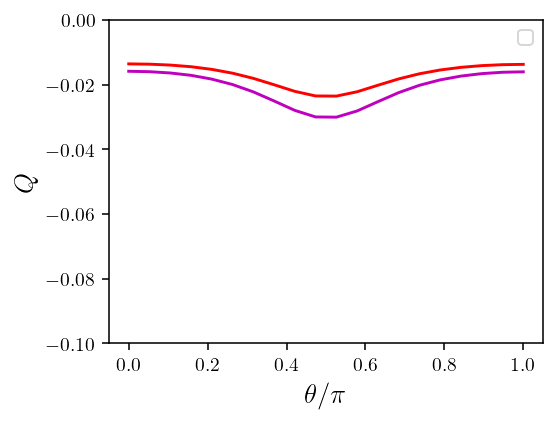

In [37]:
plt.figure(figsize=(4,3), dpi=140)
# plt.plot(thetas/np.pi,Qs_Eds, 'b', linewidth=1, label='EdS kers')
# plt.plot(thetas/np.pi,Qs, 'r', linewidth=1, label='proper kers')

plt.plot(thetas/np.pi,Qs/Qs_Eds-1, 'r')
plt.plot(thetas/np.pi,Qs_F2an/Qs_Eds-1, 'm')

m=2.8
my_an=-6*(23+12*np.cos(thetas)**2)/((7*m+8)*np.cos(thetas)**2+13)/35
# plt.plot(thetas/np.pi,fx*my_an/Qs_Eds, 'm:')
                                        
plt.xlabel(r'$\theta / \pi$', fontsize=14)
plt.ylabel(r'$Q$', fontsize=14)
plt.legend()
plt.ylim([-0.1,0])
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/bispectrumF2.pdf',bbox_inches='tight')

plt.show()

/tmp/ipykernel_2161690/2275443942.py:6: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  slope = derivative(Plin_int, klis, dx=1e-6)*klis/Plin_int(klis)


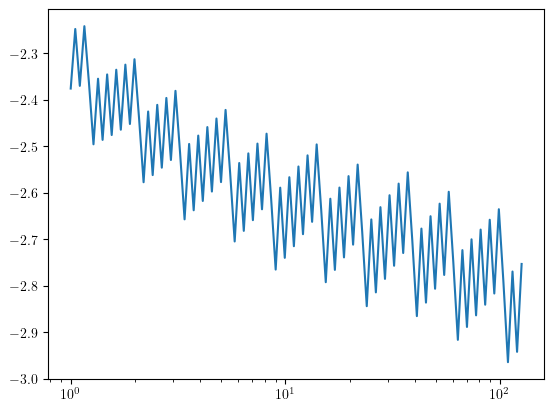

In [8]:
klis=np.logspace(0,2.1,100)

from scipy.misc import derivative

# Compute the derivative of Plin_int at klis
slope = derivative(Plin_int, klis, dx=1e-6)*klis/Plin_int(klis)

plt.plot(klis, slope)
plt.xscale(('log'))
plt.show()

-----
Plot bispectrum from measures

In [9]:
basefolder = '/home/fverdian/py-power/quijote-nu-bisp/risultati/'

mes = {}
twopi3=(2*np.pi)**3
box = 1000
grid = 128
kF=2*np.pi/box
snap = 3

for i in range(0,100):
    mesfold=basefolder+str(i)+'/'
    k1, k2, k3, P1, P2, P3, B0tot, bSN, _ = np.loadtxt(basefolder+'cdm_bs_'+str(i)+'_snap'+str(snap)+'_g128_c1s1.txt', unpack=True)

    maskk= k1<int(0.3/kF)
    PpSN=37
    
    mes.setdefault('k1', []).append(k1[maskk])
    mes.setdefault('k2', []).append(k2[maskk])
    mes.setdefault('k3', []).append(k3[maskk])
    mes.setdefault('P1', []).append(P1[maskk])
    mes.setdefault('P2', []).append(P2[maskk])
    mes.setdefault('P3', []).append(P3[maskk])
    mes.setdefault('B0', []).append(B0tot[maskk]-bSN[maskk])

for key in mes.keys():
    mes[key]=np.array(mes[key])

def mean_and_var(arr):
    Nsim=arr.shape[0]
    err = np.sqrt(np.var(arr,axis=0)/Nsim)
    mean = np.mean(arr,axis=0)
    return mean, err

k2 = 0.2450442269800039, k1 = 0.018849555921538762


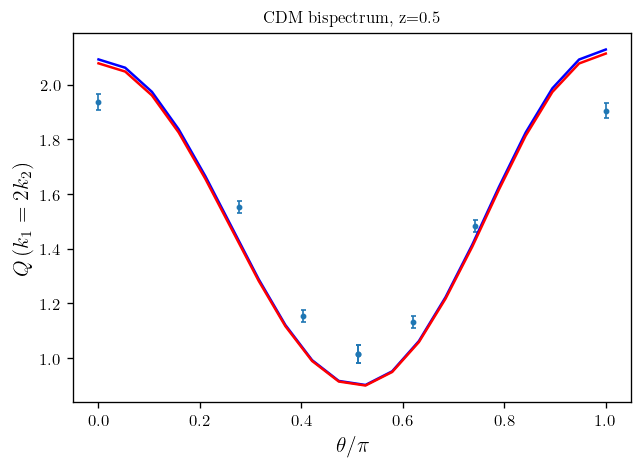

In [18]:
# Now turn to Q

kIdx=39
ratio=1/(kIdx/3)
print(f'k2 = {kIdx*kF}, k1 = {kIdx*kF*ratio}')

k1 = mes['k1'][0];k2 = mes['k2'][0];k3 = mes['k3'][0];
P1_mean,_ = mean_and_var(mes['P1'])
Plin_int=interp1d(k1*kF,P1_mean)

m_s = (k3/k1 == ratio) & (k2+k3 >= k1) & (k1==kIdx) #squeedez
m_c = (k3/k2 == ratio) & (k2+k3 >= k1) & (k2==kIdx) #collinear


Theta_s = np.pi - np.arccos((k1[m_s]**2+k3[m_s]**2-k2[m_s]**2)/(2*k1[m_s]*k3[m_s]))
Theta_c = np.pi - np.arccos((k3[m_c]**2+k2[m_c]**2-k1[m_c]**2)/(2*k3[m_c]*k2[m_c]))

kF=2*np.pi/box
Q_s, Q_s_var = mean_and_var(mes['B0'][:,m_s]/(mes['P1'][:,m_s]*mes['P2'][:,m_s]+mes['P1'][:,m_s]*mes['P3'][:,m_s]+mes['P2'][:,m_s]*mes['P3'][:,m_s]))

Q_c, Q_c_var = mean_and_var(mes['B0'][:,m_c]/(mes['P1'][:,m_c]*mes['P2'][:,m_c]+mes['P1'][:,m_c]*mes['P3'][:,m_c]+mes['P2'][:,m_c]*mes['P3'][:,m_c]))

j_Theta=np.concatenate((Theta_c,Theta_s))
j_Q=np.concatenate((Q_c,Q_s))
j_Q_var=np.concatenate((Q_c_var,Q_s_var))

plt.figure(figsize=(6,4), dpi=120)
plt.errorbar(j_Theta/np.pi,j_Q, yerr=j_Q_var, fmt='o', label=r'o',elinewidth=1, capsize=1.5, markersize=2.5)

plt.plot(thetas/np.pi,Qs_Eds, 'b')
plt.plot(thetas/np.pi,Qs, 'r')

plt.title('CDM bispectrum, z=0.5', fontsize=10)
plt.xlabel(r'$\theta/\pi$', fontsize=13)
plt.ylabel(r'$Q\,(k_1=2k_2)$', fontsize=13)

plt.show()